In [1]:
using PhyloNetworks
using Combinatorics
using Formatting
using SparseArrays
using Distributions
using MultivariateStats
using StatsBase
using CairoMakie
using MLBase
using Hungarian
using LinearAlgebra
using ParallelKMeans
using JLD
using DataFrames
using PhyloCoalSimulations
using Random
using PhyloPlots

In [2]:
function ground_true(df_1, df_2)
    a = fill(1,size(df_1)[1])
    b = fill(2,size(df_2)[1])
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree)');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function plot_clusters(tree, label)
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end


function kmeans_label(tree, n; seed =:"k-means++")  
    result = kmeans(tree, n; k_init = seed);
    return result.assignments
end

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

accuracy (generic function with 1 method)

In [5]:
function num_bipartitions(n)
    return 2^(n-1) - 1
end;

function show_bipartitions(n, start=0, stop=nothing)
    idx_width = length(string(num_bipartitions(n)))
    idx_fmt = FormatSpec(string(">", idx_width, "s"))
    node_width = length(string(n))
    node_fmt = FormatSpec(string(">", node_width, "s"))
    idx = 0
    node = Vector(1:n)
    println("idx\tpartition")
    for i in range(1, n÷2)
        
        comb = combinations(Vector(1:n), i)
        if i == n - i
            comb = Iterators.take(comb,  binomial(n,i)÷ 2)
        end
            
        for c in comb
            if start <= idx && (stop === nothing || idx <= stop)
                printfmt(idx_fmt, idx)
                print("\t")
                for e in c
                    printfmt(node_fmt, e)
                    print(" ")
                end
                print("| ")
                for e in sort(collect(setdiff(node ,Set(c))))
                    printfmt(node_fmt, e)
                    print(" ")
                end
                println()
            end
            idx += 1
        end
    end
end;

function show_bipartition(n, idx)
    show_bipartitions(n,idx,idx)
end;

# get the nodes that the branch has. 
function get_nodes(idx)
    nodes = []
    for i in 1:length(idx)
        if idx[i]
            append!(nodes, i)
        end
    end
    return nodes
end


function get_bipartition(tree, n)
    taxa = sort(tipLabels(tree))
    if length(taxa) != n
        print("check the parameter n")
        return
    end
    node = Vector(1:n)
    result = []
    idx = 0
    for i in tree.edge
        node_idx = hardwiredCluster(i,taxa)
        branch_node = get_nodes(node_idx)
        
        # if branch seperates more than half nodes, we use the small part to get bipartition idx
        if (length(branch_node) > n ÷ 2)
             branch_node = sort(collect(setdiff(node,branch_node)))
        end
        
        # generate all possible combination with the same number of nodes
        comb = collect(combinations(Vector(1:n), length(branch_node)))
        for c in 1:length(comb)
            if comb[c] == branch_node
                # if the combination is the later, we need to find its first half
                if length(branch_node) > 1 && c > length(comb) ÷ 2
                    c = length(comb) - c + 1 
                end
                idx = c - 1
                break
            end
        end
        for j in 1:(length(branch_node) - 1)
            idx = idx + binomial(n,j)
        end
        push!(result,Pair(idx, i.length))
        idx = 0
    end
    return result
end;

# trees is dataframe

function print_bipartition(trees, n)
    
    # build the table
    N = num_bipartitions(n)
    data = zeros(length(trees), N)
    treeNum = 1;
    # get existing index
    
    for i in trees
        bipart = get_bipartition(i, n)
        for j in 1:length(bipart)
            data[treeNum,(bipart[j][1] + 1)] += bipart[j][2]
        end
        treeNum+=1
    end
    return data
end;

In [4]:
tree2_1 = jldopen("chosen/16_diff_topo_2_100_1.jld", "r") do file
    read(file, "tree")
end

tree2_2 = jldopen("chosen/16_diff_topo_2_100_2.jld", "r") do file
    read(file, "tree")
end

tree9_1 = jldopen("chosen/16_diff_topo_9_100_1.jld", "r") do file
    read(file, "tree")
end

tree9_2 = jldopen("chosen/16_diff_topo_9_100_2.jld", "r") do file
    read(file, "tree")
end


100×32767 SparseMatrixCSC{Float64, Int64} with 2843 stored entries:
⠛⠛⠁⠛⠃⠃⠀⠀⠘⠃⠂⠋⠛⠀⠀⠀⠀⠀⠛⠃⠈⠁⠋⠃⠘⠀⠀⠀⠀⠀⠀⠀⠃⠀⠀⠀⠀⠈⠃⠂

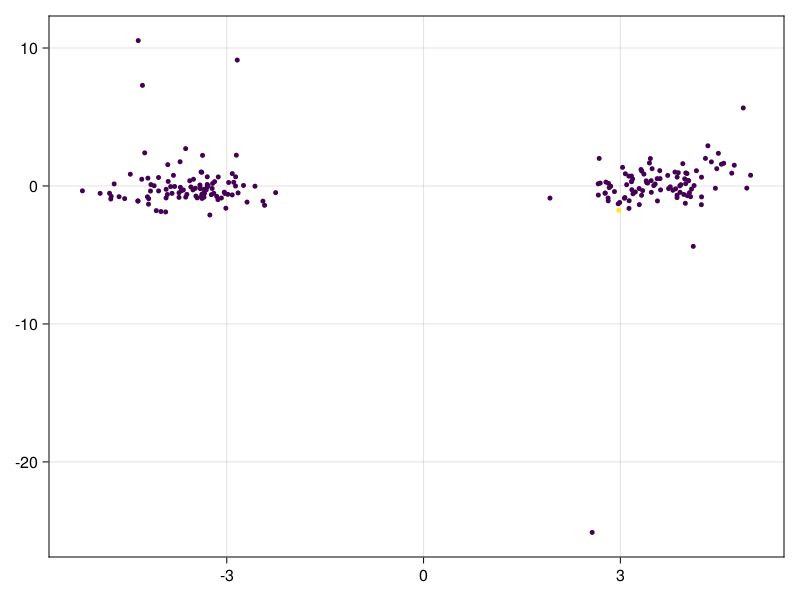

In [6]:
gt = ground_true(tree2_1,tree9_1)
tree = vcat(tree2_1,tree9_1)
tree = standardize_tree(tree)
pred_kmeans = kmeans_label(tree, 2)
plot_clusters(tree, pred_kmeans)

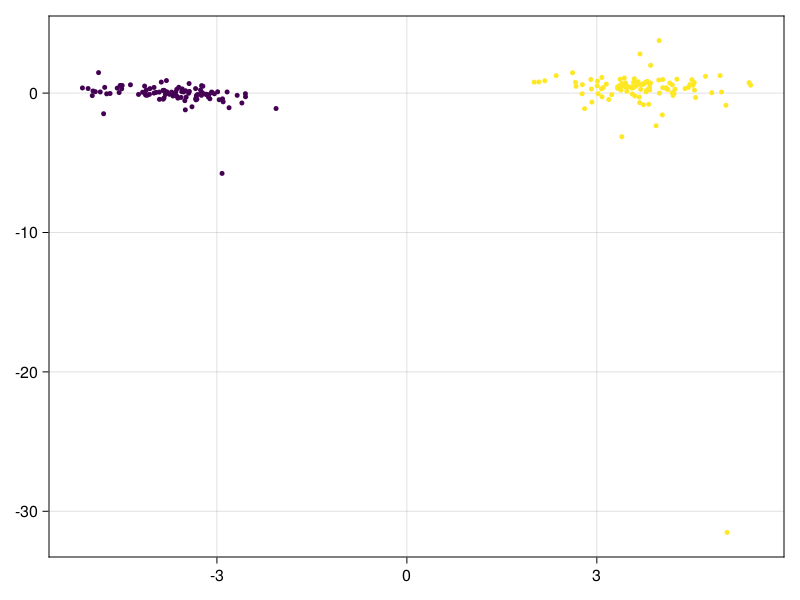

In [41]:
gt = ground_true(tree2_2,tree9_2)
tree = vcat(tree2_2,tree9_2)
tree = standardize_tree(tree)
Random.seed!(123)
pred_kmeans = kmeans_label(tree, 2)
plot_clusters(tree, pred_kmeans)

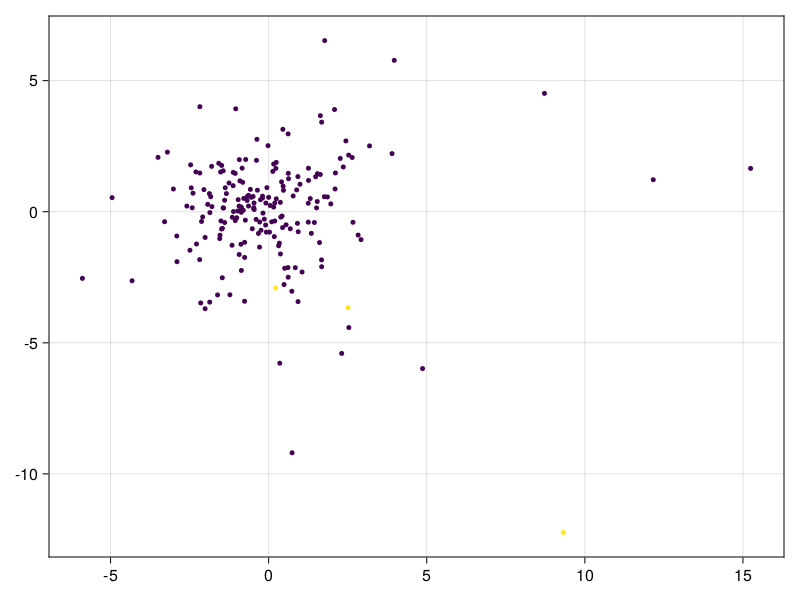

In [9]:
gt = ground_true(tree2_2,tree2_1)
tree = vcat(tree2_2,tree2_1)
tree = standardize_tree(tree)
pred_kmeans = kmeans_label(tree, 2)
plot_clusters(tree, pred_kmeans)

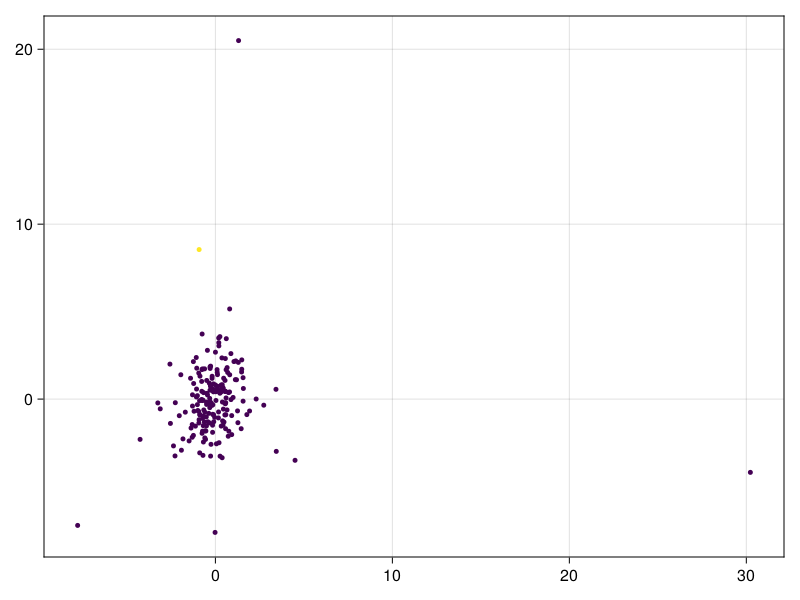

In [80]:
gt = ground_true(tree9_2,tree9_1)
tree = vcat(tree9_2,tree9_1)
tree = standardize_tree(tree)
pred_kmeans = kmeans_label(tree, 2)
plot_clusters(tree, pred_kmeans)

In [23]:
case2 = "(((10:0.0,(8:0.0,1:0.0):0.0):0.0,((12:0.0,11:0.0):0.0,(2:0.0,5:0.0):0.0):0.0):0.0,((3:0.0,(((14:0.0,16:0.0):0.0,(15:0.0,4:0.0):0.0):0.0,6:0.0):0.0):0.0,((9:0.0,7:0.0):0.0,13:0.0):0.0):0.0);"
case9 = "((3:0.0,(5:0.0,2:0.0):0.0):0.0,(((8:0.0,(13:0.0,9:0.0):0.0):0.0,16:0.0):0.0,((((6:0.0,10:0.0):0.0,(11:0.0,15:0.0):0.0):0.0,((12:0.0,4:0.0):0.0,1:0.0):0.0):0.0,(7:0.0,14:0.0):0.0):0.0):0.0);"
trees_string = [case2, case9]

2-element Vector{String}:
 "(((10:0.0,(8:0.0,1:0.0):0.0):0." ⋯ 128 bytes ⋯ ",7:0.0):0.0,13:0.0):0.0):0.0);"
 "((3:0.0,(5:0.0,2:0.0):0.0):0.0," ⋯ 128 bytes ⋯ "(7:0.0,14:0.0):0.0):0.0):0.0);"

In [24]:
d = Uniform(0.5, 2)
trees = []
for j in 1:length(trees_string)
    tree = readTopology(trees_string[j])
    Random.seed!(123+j)
    n = length(tree.edge)

    x = rand(d, n)
    idx = 1
    for e in tree.edge
        e.length += x[idx]
        e.length = round(e.length, digits = 2)
        idx += 1
    end
    tree = simulatecoalescent(tree, 100, 1);
    trees = vcat(trees, tree)
end

In [25]:
hardwiredClusterDistance(trees[1],trees[2],false)

10

In [30]:
matrix = zeros(200,200)
for i in 1:200
    for j in  i:200
        matrix[i,j] = matrix[j,i] = hardwiredClusterDistance(trees[i],trees[j],false)
    end
end

In [31]:
matrix

200×200 Matrix{Float64}:
  0.0  10.0  10.0   6.0   8.0  10.0  …  26.0  24.0  24.0  24.0  26.0  24.0
 10.0   0.0   8.0   6.0  10.0   8.0     26.0  24.0  24.0  24.0  26.0  24.0
 10.0   8.0   0.0   8.0  10.0   6.0     26.0  24.0  24.0  24.0  26.0  24.0
  6.0   6.0   8.0   0.0   6.0   8.0     26.0  24.0  24.0  24.0  26.0  24.0
  8.0  10.0  10.0   6.0   0.0  10.0     26.0  24.0  24.0  24.0  26.0  24.0
 10.0   8.0   6.0   8.0  10.0   0.0  …  26.0  24.0  24.0  24.0  26.0  24.0
  6.0  12.0  10.0   8.0  10.0  10.0     26.0  26.0  26.0  26.0  26.0  26.0
 14.0  14.0  14.0  12.0  18.0  14.0     26.0  24.0  24.0  24.0  26.0  24.0
 12.0  12.0  14.0  12.0  14.0  10.0     26.0  24.0  24.0  24.0  26.0  24.0
  4.0  12.0  10.0   8.0  10.0  10.0     24.0  22.0  22.0  22.0  26.0  24.0
  8.0  10.0   6.0   6.0   8.0   4.0  …  26.0  24.0  24.0  24.0  26.0  24.0
 12.0  12.0  10.0  10.0  14.0  14.0     26.0  24.0  24.0  24.0  26.0  24.0
  6.0  10.0   8.0   6.0   8.0   8.0     24.0  22.0  22.0  22.0  26.0  24.0


In [32]:
tree = PhyloNetworks.nj!(matrix)

HybridNetwork, Un-rooted Network
397 edges
398 nodes: 200 tips, 0 hybrid nodes, 198 internal tree nodes.
tip labels: 1, 2, 3, 4, ...
(((((((((((((((((((((1:2.687,(10:1.258,41:0.742):0.313):0.558,44:1.942):1.058,(((24:1.18,62:0.82):1.056,((39:0.0,100:0.0):0.777,97:1.223):0.944):0.69,31:2.81):0.192):0.56,(((13:0.714,19:1.286):1.251,89:2.749):0.746,75:3.254):0.346):0.266,(9:3.786,91:2.214):1.78):0.664,34:4.711):1.525,((((((2:1.919,37:2.081):1.078,60:2.922):1.905,((5:3.168,(96:1.588,98:2.412):0.832):1.307,92:4.693):0.533):0.538,88:5.494):1.005,((((((((((((3:0.0,42:0.0):0.899,50:3.101):0.78,(18:0.0,68:0.0):1.22):0.92,(35:1.29,69:2.71):1.08):0.383,((53:1.627,(61:1.334,81:0.666):0.373):0.747,(54:1.317,57:0.683):1.253):0.867):0.192,(((58:2.462,(76:2.598,95:1.402):0.538):0.601,(86:2.818,90:1.182):1.899):1.002,(78:0.827,83:1.173):1.623):0.48):0.094,((((4:1.298,(43:0.0,71:0.0):0.702):0.502,(46:1.009,59:0.991):0.498):0.796,(((23:0.0,80:0.0):1.06,(48:1.354,56:0.646):0.94):0.439,(26:0.661,36:1.339):

In [37]:
plot(tree, :R);

LoadError: PlotMethodError: no [36mplot[39m method for arguments [36m(::HybridNetwork, ::Symbol)[39m. To support these arguments, define
  [36mplot!(::Combined{Any, S} where S<:Tuple{HybridNetwork, Symbol})[39m
Available methods are:
  plot!(plot::Combined{Any, <:Tuple{AbstractVector{<:Complex}}}) in Makie at C:\Users\82537\.julia\packages\Makie\Ppzqh\src\basic_recipes\convenience_functions.jl:1
